# Reinforcement Learning - Trading example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)](https://medium.com/towards-data-science/modern-route-optimization-with-python-fea87d34288b)

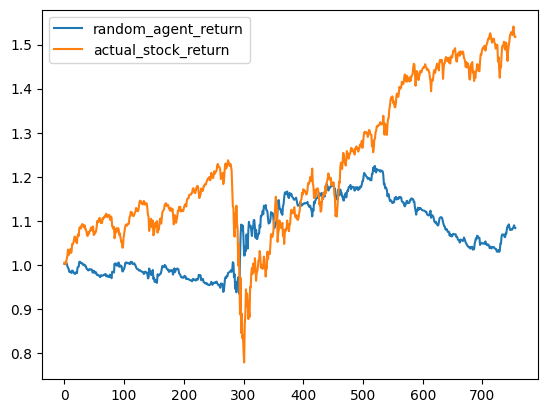

In [49]:
import gym
from gym.envs.registration import register
from gym import error, spaces, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import arrow
import random
import sys

class TradingEnv(gym.Env):
    def __init__(self, start_date, end_date, tc=0.05/100, ticker='^DJI'):
        self.start = start_date
        self.end = end_date
        self.tc = tc
        self.ticker = ticker
        self.action_space = spaces.Discrete(1)
        self.observation_space = spaces.Box(low=-1,high=1,dtype=np.float32)
        returns = self.load_dataset()
        self.data_df = self.create_features(returns)
        self.curr_index = 0
        self.data_len = self.data_df.shape[0]
        self.action = 0

    def step(self, action):

        done = False
        stock_return = self.extract_return(self.data_df, self.curr_index)
        change_in_position = np.abs(self.action - action)
        cost = change_in_position * self.tc
        reward = action*stock_return - cost

        if self.curr_index == self.data_len - 2:
            done = True
        self.curr_index += 1
        self.action = action

        obs = self.extract_state(self.data_df, self.curr_index).values

        info = { 'date' : self.data_df.index[self.curr_index], 'return' : stock_return }

        return obs, reward, done, info

    def reset(self):
        self.curr_index = 0
        return self.extract_state(self.data_df, self.curr_index).values

    def render(self,mode='human'):
        pass

    def extract_return(self, df, i):
        return df.iloc[i]['Y']

    def extract_state(self, df, i):
        return df.iloc[i][['r%d' % i for i in range(5)]]

    def load_dataset(self):
        df = web.DataReader(self.ticker, 'stooq')
        mask = ( self.start <= df.index ) & ( df.index <= self.end )
        df = df[mask]
        df = df.sort_values(by='Date')
        returns = df['Close'].pct_change()
        return returns

    def create_features(self, returns):
        dfs = []
        for i in range(5):
            dfs.append(returns.shift(i).rename('r%d'%i))
        dfs.append(returns.shift(-1).rename('Y'))
        df_net = pd.concat(dfs, axis=1)
        df_net = df_net.dropna()
        return df_net

ENV_NAME = 'TradingEnv-v0'

reg = register(
    id=ENV_NAME,
    entry_point='__main__:TradingEnv',
    kwargs={
        'start_date' : '2019-01-01',
        'end_date' : '2022-01-10',
    }
)

if __name__ == '__main__':

    env = gym.make(ENV_NAME)
    obs = env.reset()
    done = False

    reward_returns = []
    while not done:
        action = random.uniform(-1,1)
        obs, reward, done, info = env.step(action)
        reward_returns.append( (reward,info['return']) )

    i = list(range(len(reward_returns)))
    agent_returns = np.cumprod([ 1 + x[0] for x in reward_returns ])
    stock_returns = np.cumprod([ 1 + x[1] for x in reward_returns ])

    plt.plot(i, agent_returns, label='random_agent_return')
    plt.plot(i, stock_returns, label='actual_stock_return')
    plt.legend()
    plt.show()

### 0 - Setup

###### Import pckgs

In [25]:
import warnings
warnings.filterwarnings("ignore")

## for data
import yfinance as yf  #0.2.22
import numpy as np  #1.24.4
import pandas as pd  #2.0.3

## for env
import gymnasium as gym  #0.28.1
from gymnasium import spaces

###### Import data

In [3]:
x = "EURHKD=X"

data = yf.Ticker(x).history(period="1y")  #1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-07-04 00:00:00+01:00,8.18865,8.20800,8.17140,8.18510,0,0.0,0.0
2022-07-05 00:00:00+01:00,8.18612,8.19741,8.03260,8.18520,0,0.0,0.0
2022-07-06 00:00:00+01:00,8.04693,8.06153,7.97316,8.04828,0,0.0,0.0
2022-07-07 00:00:00+01:00,7.98879,8.01917,7.96700,7.99095,0,0.0,0.0
2022-07-08 00:00:00+01:00,7.98054,7.99735,7.91125,7.97894,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-28 00:00:00+01:00,8.58160,8.58674,8.53774,8.58140,0,0.0,0.0
2023-06-29 00:00:00+01:00,8.54981,8.57175,8.51184,8.55060,0,0.0,0.0
2023-06-30 00:00:00+01:00,8.51898,8.56519,8.48934,8.51845,0,0.0,0.0


### 1 - Environment

###### Create env

In [ ]:
class NewEnv(gym.Env):
    
    def __init__(self, data):
        ## data
        self.data = data
        ## actions
        self.action_space = spaces.Discrete(1)
        self.observation_space = spaces.Box(low=-1, high=1)
        self.action = 0
        ## state
        self.state = 0
        self.portfolio = 0
        
        
    '''
    Reset the state of the env to an initial state and set the current step to a random point within the data
    '''
    def reset(self, from_zero=True):
        self.state = 0 if from_zero is True else np.random.randint(len(self.data))
        return self.state
    
    
    '''
    Take the action
    '''
    def decide_action(self):
        action = random.uniform(-1,1)
        
    
    
    '''
    Get new state after action or reset
    '''
    def calculate_state(self):
        state = np.append(self.data.iloc[self.current_step].values, [[self.balance, self.N, self.P0]])
    
    
    '''
    Decide whether the episode is done after action
    '''
    def is_done(self):
    
    
    '''
    Compute reward after action
    '''
    def calculate_reward(self):
        self.data
    
    
    '''
    Main function
    '''    
    def step(self, action):
        return new_state, reward, done
    

###### Load env

###### Random play

In [10]:
Q = pd.DataFrame(np.zeros(shape=(len(data),env.actions_space)), 
                 columns=["sell","hold","buy"], index=data.index)
Q.head()

NameError: name 'pd' is not defined

In [ ]:
R = pd.DataFrame(np.zeros(shape=(len(data),env.actions_space)), 
                 columns=["sell","hold","buy"], index=data.index)
R.head()

In [ ]:
def get_next_action(current_state):            
    ## Explore: select a random action
    if np.random.uniform(0,1) < self.explore_rate:
        action = np.random.randint(0, self.actions_space)
    ## Exploit: select the action with max q_value
    else:
        current_qs = self.Q[current_state]
        action = np.argmax( current_qs )
    return action

In [ ]:
obs = env.reset()
done = False

rewards = []
while not done:
    action = random.uniform(-1,1)
    new_state, reward, done = env.step(action)
    reward_returns.append( (reward,info['return']) )

i = list(range(len(reward_returns)))
agent_returns = np.cumprod([ 1 + x[0] for x in reward_returns ])
stock_returns = np.cumprod([ 1 + x[1] for x in reward_returns ])

plt.plot(i, agent_returns, label='random_agent_return')
plt.plot(i, stock_returns, label='actual_stock_return')
plt.legend()
plt.show()

### 2 - Simple Q Learning

### 3 - Deep Q Learning